Stitching together some of Jiaxuan's code to ensure I'm reproducing the SBP's he found with Dragonfly

In [1]:
import matplotlib.pyplot as plt
from astropy.table import Table
import h5py
import os
import numpy as np
import cosmology
from astropy.table import join
from esutil import htm
from legacyhalos.qa import display_ellipsefit
from photutils.aperture import EllipticalAperture
from photutils.isophote import EllipseGeometry

# From Jiaxuan repo
HSC_pixel_scale = 0.168
DECaLS_pixel_scale = 0.262
Dragonfly_pixel_scale = 2.5
SDSS_pixel_scale = 0.395
HSC_zeropoint = 27.0
DECaLS_zeropoint = 22.5
SDSS_zeropoint = 22.5

def flux_to_mag(flux, zero_point=DECaLS_zeropoint):
    return (-5/2)*np.log10(flux) + zero_point

In [2]:
jiaxuan_cat = Table.read("/Users/matt/Data/legacydata/jiaxuan_data/s16a_massive_z_0.5_logm_11.4_decals_full_fdfc_bsm_ell_decals_2021_07.fits")

Construct a catalog of SV3 joined to Jiaxuan's DECaLS data to run legacyhalos on

In [3]:
sv3_cat = Table.read("/Users/matt/Data/legacydata/sv3-clustering/BGS_BRIGHT_S_clustering.dat.fits")

# Add a join ID to later join on
jiaxuan_cat.add_column(0, name="join_id")
sv3_cat.add_column(0, name="join_id")

# Add flux from SV3 to provide to legacyhalos
mag_r_dered = flux_to_mag(sv3_cat["flux_r_dered"])
sv3_cat.add_column(mag_r_dered, name="mag_r_dered")

# Match the two catalogs using RA/DEC 1 arcsecond
matcher = htm.HTM()

sv3_ra = sv3_cat["RA"]
sv3_dec = sv3_cat["DEC"]

j_ra = jiaxuan_cat["ra"]
j_dec = jiaxuan_cat["dec"]

idx_sv3, idx_j, _ = matcher.match(sv3_ra, sv3_dec, j_ra, j_dec, 1.0/3600)
matches = [
    (sv3_cat[x], jiaxuan_cat[y]) for x, y in zip(idx_sv3, idx_j)
]

Create a dummy Foreign Key to join on

In [2]:
# Assign a unique ID to each matched row
unique_id = 1
for x, y in zip(idx_sv3, idx_j):
    sv3_cat[x]["join_id"] = unique_id
    jiaxuan_cat[y]["join_id"] = unique_id
    unique_id += 1

# Filter our table to only matched rows
sv3_matches = sv3_cat[sv3_cat["join_id"]>0]
jiaxuan_matches = jiaxuan_cat[jiaxuan_cat["join_id"]>0]

# Join on the unique ID for a combined table
combined_cat = join(sv3_matches, jiaxuan_matches, keys="join_id")
combined_cat.remove_column("ra")
combined_cat.remove_column("dec")

# QA check to ensure matched rows are accurate
for s, j in matches:
    this_row = combined_cat[combined_cat["TARGETID"]==s["TARGETID"]]
    assert this_row["id_s16a"] == j["id_s16a"]

combined_cat.write("/Users/matt/Data/legacydata/jiaxuan_data/sv3_matches.fits", overwrite=True)

NameError: name 'idx_sv3' is not defined

After running legacyhalos on the above data, we pull the ellipse fit, tractor, and sample data and write them to fits files. 

Below, we combine the sample (ref cat) and ellipse fit data

In [4]:
data_path = '/Users/matt/Data/legacydata/jiaxuan_data'
ellipse_nm = 'total_ellipse.fits'
tractor_nm = 'total_tractor.fits'
sample_nm = 'total_sample.fits'

sv3_ellipses = Table.read(os.path.join(data_path, ellipse_nm))
tractor = Table.read(os.path.join(data_path, tractor_nm))
sample = Table.read(os.path.join(data_path, sample_nm))

# Join ref id's... ID_CENT == TARGETID
ellipse_cat = join(sv3_ellipses, sample, keys_left="ID_CENT", keys_right="TARGETID")

In [17]:
print(tractor.colnames)

['release', 'brickid', 'brickname', 'objid', 'brick_primary', 'maskbits', 'fitbits', 'type', 'ra', 'dec', 'ra_ivar', 'dec_ivar', 'bx', 'by', 'dchisq', 'ebv', 'mjd_min', 'mjd_max', 'ref_cat', 'ref_id', 'pmra', 'pmdec', 'parallax', 'pmra_ivar', 'pmdec_ivar', 'parallax_ivar', 'ref_epoch', 'gaia_phot_g_mean_mag', 'gaia_phot_g_mean_flux_over_error', 'gaia_phot_g_n_obs', 'gaia_phot_bp_mean_mag', 'gaia_phot_bp_mean_flux_over_error', 'gaia_phot_bp_n_obs', 'gaia_phot_rp_mean_mag', 'gaia_phot_rp_mean_flux_over_error', 'gaia_phot_rp_n_obs', 'gaia_phot_variable_flag', 'gaia_astrometric_excess_noise', 'gaia_astrometric_excess_noise_sig', 'gaia_astrometric_n_obs_al', 'gaia_astrometric_n_good_obs_al', 'gaia_astrometric_weight_al', 'gaia_duplicated_source', 'gaia_a_g_val', 'gaia_e_bp_min_rp_val', 'gaia_phot_bp_rp_excess_factor', 'gaia_astrometric_sigma5d_max', 'gaia_astrometric_params_solved', 'flux_g', 'flux_r', 'flux_z', 'flux_ivar_g', 'flux_ivar_r', 'flux_ivar_z', 'fiberflux_g', 'fiberflux_r', 'fib

These functions were taken from Jiaxuan's slug repo

His repo has a lot of dependencies and no quick way to install them all, so I just took the functions I needed

In [5]:
def phys_size_fn(redshift, is_print=True, H0=70, Omegam=0.3, Omegal=0.7):
    '''Calculate the corresponding physical size per arcsec of a given redshift
    in the Lambda-CDM cosmology.

    Requirement:
    -----------
    cosmology: https://github.com/esheldon/cosmology
    
    Parameters:
    -----------
    redshift: float
    is_print: boolean. If true, it will print out the physical scale at the given redshift.
    Omegam: float, density parameter of matter. It should be within [0, 1]. 
    Omegal: float, density parameter of Lambda.

    Returns:
    -----------
    physical_size: float, in 'kpc/arcsec'
    '''
    cosmos = cosmology.Cosmo(H0=H0, omega_m=Omegam, flat=True, omega_l=Omegal, omega_k=None)
    ang_distance = cosmos.Da(0.0, redshift)
    physical_size = ang_distance/206265*1000 # kpc/arcsec
    if is_print:
        print ('At redshift', redshift, ', 1 arcsec =', physical_size, 'kpc')
    return physical_size

In [6]:
# You can plot 1-D SBP using this, without plotting the PA and eccentricity.
def SBP_single(ell_fix, redshift, pixel_scale, zeropoint, ax=None, offset=0.0, 
    x_min=1.0, x_max=4.0, alpha=1, physical_unit=False, show_dots=False, show_grid=False, 
    show_banner=True, vertical_line=None, linecolor='firebrick', linestyle='-', 
    linewidth=3, labelsize=25, ticksize=30, label='SBP', labelloc='lower left'):

    """Display the 1-D profiles, without showing PA and ellipticity.
    
    Parameters:
    -----------
    ell_fix: astropy Table or numpy table, should be the output of ELLIPSE.
    redshift: float, redshift of the object.
    pixel_scale: float, pixel scale in arcsec/pixel.
    zeropoint: float, zeropoint of the photometry system.
    ax: matplotlib axes class.
    offset: float.
    x_min, x_max: float, in ^{1/4} scale.
    alpha: float, transparency.
    physical_unit: boolean. If true, the figure will be shown in physical scale.
    show_dots: boolean. If true, it will show all the data points.
    show_grid: boolean. If true, it will show a grid.
    vertical_line: list of floats, positions of vertical lines. Maximum length is three.
    linecolor, linestyle: string. Color and style of SBP.
    label: string.

    Returns:
    --------
    ax: matplotlib axes class.

    """
    if ax is None:
        fig = plt.figure(figsize=(10, 10))
        fig.subplots_adjust(left=0.0, right=1.0, 
                            bottom=0.0, top=1.0,
                            wspace=0.00, hspace=0.00)

        ax1 = fig.add_axes([0.08, 0.07, 0.85, 0.88])
        ax1.tick_params(direction='in')
    else:
        ax1 = ax
        ax1.tick_params(direction='in')

    # Calculate physical size at this redshift
    phys_size = phys_size_fn(redshift, is_print=False)

    # 1-D profile
    if 'intens_err' in ell_fix.colnames:
        intens_err_name = 'intens_err'
    else:
        intens_err_name = 'int_err'

    if physical_unit is True:
        x = ell_fix['sma'] * pixel_scale * phys_size
        y = -2.5 * np.log10((ell_fix['intens'].data + offset) / (pixel_scale)**2) + zeropoint
        y_upper = -2.5 * np.log10((ell_fix['intens'] + offset + ell_fix[intens_err_name]) / (pixel_scale)**2) + zeropoint
        y_lower = -2.5 * np.log10((ell_fix['intens'] + offset - ell_fix[intens_err_name]) / (pixel_scale)**2) + zeropoint
        upper_yerr = y_lower - y
        lower_yerr = y - y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{kpc})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/arcsec^2}]$'
    else:
        x = ell_fix['sma'] * pixel_scale
        y = -2.5 * np.log10((ell_fix['intens'].data + offset) / (pixel_scale)**2) + zeropoint
        y_upper = -2.5 * np.log10((ell_fix['intens'] + offset + ell_fix[intens_err_name]) / (pixel_scale) ** 2) + zeropoint
        y_lower = -2.5 * np.log10((ell_fix['intens'] + offset - ell_fix[intens_err_name]) / (pixel_scale) ** 2) + zeropoint
        upper_yerr = y_lower - y
        lower_yerr = y - y_upper
        asymmetric_error = [lower_yerr, upper_yerr]
        xlabel = r'$(R/\mathrm{arcsec})^{1/4}$'
        ylabel = r'$\mu\,[\mathrm{mag/arcsec^2}]$'
    
    # If `nan` at somewhere, interpolate `nan`.
    if show_grid:
        ax1.grid(linestyle='--', alpha=0.4, linewidth=2)
    if show_dots:
        ax1.errorbar((x ** 0.25), y,
                 yerr=asymmetric_error,
                 color='k', alpha=0.2, fmt='o', 
                 capsize=4, capthick=1, elinewidth=1)

    if label is not None:
        ax1.plot(x**0.25, y, color=linecolor, linewidth=linewidth, linestyle=linestyle,
             label=r'$\mathrm{' + label + '}$', alpha=alpha)
        leg = ax1.legend(fontsize=labelsize, frameon=False, loc=labelloc)
        for l in leg.legendHandles:
            l.set_alpha(1)
    else:
        ax1.plot(x**0.25, y, color=linecolor, linewidth=linewidth, linestyle=linestyle, alpha=alpha)
    ax1.fill_between(x**0.25, y_upper, y_lower, color=linecolor, alpha=0.3*alpha, label=None)
    
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize)
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(ticksize)

    ax1.set_xlim(x_min, x_max)
    ax1.set_xlabel(xlabel, fontsize=ticksize)
    ax1.set_ylabel(ylabel, fontsize=ticksize)
    ax1.invert_yaxis()

    # Twin axis with linear scale
    if physical_unit and show_banner is True:
        ax4 = ax1.twiny() 
        ax4.tick_params(direction='in')
        lin_label = [1, 2, 5, 10, 50, 100, 150, 300]
        lin_pos = [i**0.25 for i in lin_label]
        ax4.set_xticks(lin_pos)
        ax4.set_xlim(ax1.get_xlim())
        ax4.set_xlabel(r'$\mathrm{kpc}$', fontsize=ticksize)
        ax4.xaxis.set_label_coords(1, 1.025)

        ax4.set_xticklabels([r'$\mathrm{'+str(i)+'}$' for i in lin_label], fontsize=ticksize)
        for tick in ax4.xaxis.get_major_ticks():
            tick.label.set_fontsize(ticksize)

    plt.sca(ax1)
    
    # Vertical line
    if vertical_line is not None:
        if len(vertical_line) > 3:
            raise ValueError('Maximum length of vertical_line is 3.') 
        ylim = ax1.get_ylim()
        style_list = ['-', '--', '-.']
        for k, pos in enumerate(vertical_line):
            ax1.axvline(x=pos**0.25, ymin=0, ymax=1,
                        color='gray', linestyle=style_list[k], linewidth=3, alpha=0.75)
        plt.ylim(ylim)

    # Return
    if ax is None:
        return fig
    return ax1

In [12]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_41699/874435152.py:54: RuntimeWarning: invalid value encountered in log10
  y = -2.5 * np.log10((ell_fix['intens'].data + offset) / (pixel_scale)**2) + zeropoint
/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_41699/874435152.py:56: RuntimeWarning: invalid value encountered in log10
  y_lower = -2.5 * np.log10((ell_fix['intens'] + offset - ell_fix[intens_err_name]) / (pixel_scale)**2) + zeropoint
/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_41699/874435152.py:86: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for l in leg.legendHandles:
/var/folders/rn/gdlml1w17ds9ks621h70g9hw0000gn/T/ipykernel_41699/874435152.py:93: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(ticksize)


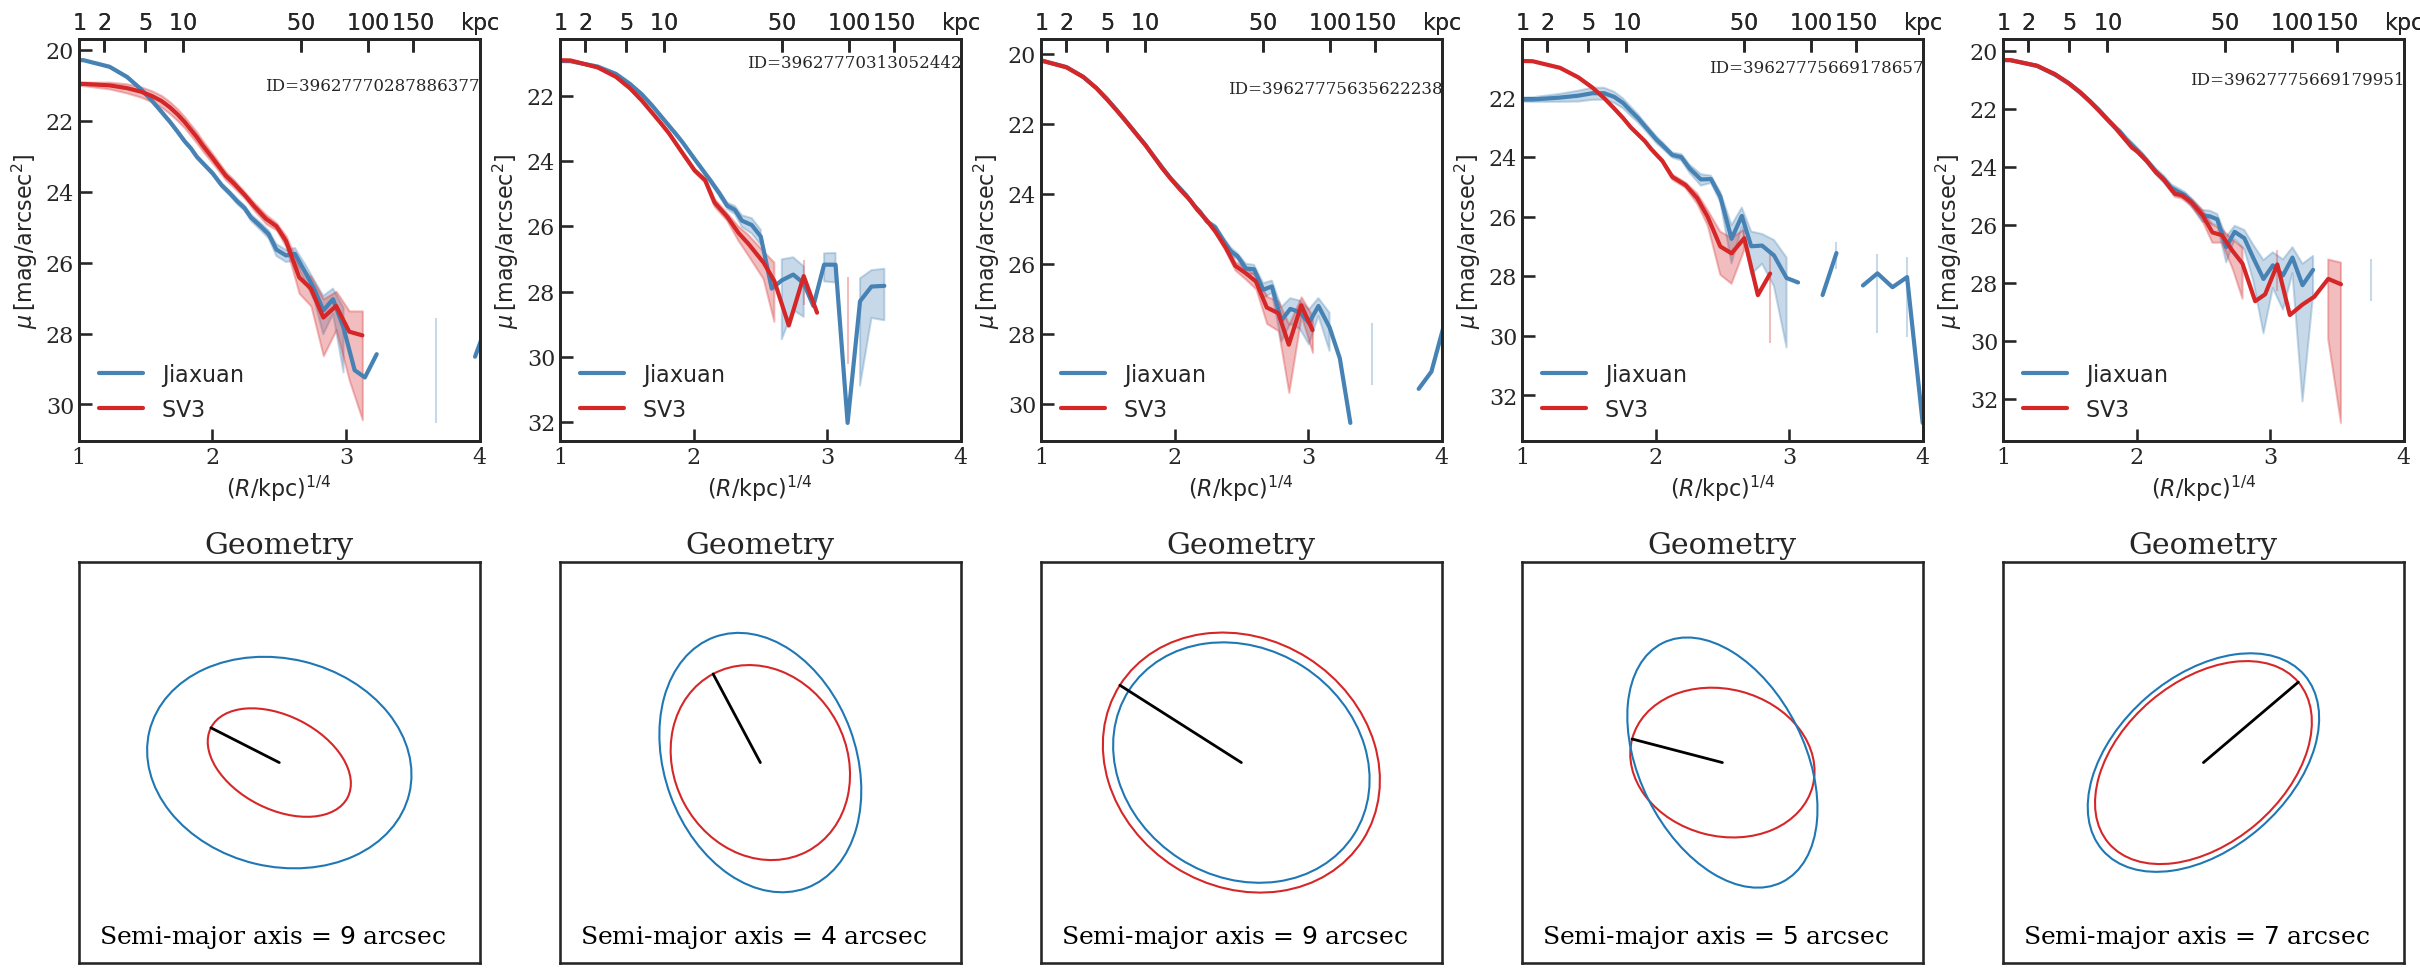

In [35]:
fig, (axes, axes2) = plt.subplots(2, 5, figsize=(30, 12))

for i, my_fit in enumerate(ellipse_cat[100:105]):
    
    # For this HSC ID, grab Jiaxuan's fit data
    s16a_id = str(my_fit['ID_S16A'])
    filenm = f'{s16a_id}/{s16a_id}-custom-{s16a_id}-ellipse.fits'
    path = f"/Users/matt/Data/legacydata/jiaxuan_data/DECaLS-data-2021-07/{s16a_id[:4]}/"
    ellipsefit_j = Table.read(os.path.join(path, filenm))
    jz = jiaxuan_cat[jiaxuan_cat['id_s16a'] == int(s16a_id)]['z_best']

    ax = axes[i]

    ell_decals = Table(
        data=[
            ellipsefit_j['R_SMA'].data[0],  # pixel
            ellipsefit_j['R_INTENS'].data[0] * (DECaLS_pixel_scale)**
            2,  # nanomaggie/pixel
            ellipsefit_j['R_INTENS_ERR'].data[0] * (DECaLS_pixel_scale)**
            2  # nanomaggie/pixel
        ],
        names=['sma', 'intens', 'intens_err'])

    ax=SBP_single(
        ell_decals,
        jz,
        pixel_scale=DECaLS_pixel_scale,
        zeropoint=DECaLS_zeropoint,
        ax=ax,
        physical_unit=True,
        linecolor='steelblue',
        label='Jiaxuan',
        x_max=4,
        ticksize=16, labelsize=16, 
        show_banner=True)
    
    # Compare with SV3 results
    ell_sv3 = Table(
        data=[
            my_fit['SMA_R'],  # pixel
            my_fit['INTENS_R'] * (DECaLS_pixel_scale)**
            2,  # nanomaggie/pixel
            my_fit['INTENS_ERR_R'] * (DECaLS_pixel_scale)**
            2  # nanomaggie/pixel
        ],
        names=['sma', 'intens', 'intens_err'])
    
    ax=SBP_single(
        ell_sv3,
        my_fit["Z"],
        pixel_scale=DECaLS_pixel_scale,
        zeropoint=DECaLS_zeropoint,
        ax=ax,
        physical_unit=True,
        linecolor='tab:red',
        label='SV3',
        x_max=4,
        ticksize=16, labelsize=16, 
        show_banner=True)

    ax.invert_yaxis()

    ax_lower = axes2[i]

    sma = my_fit["SMA_MOMENT"] 
    pa = my_fit["PA_MOMENT"] * np.pi/180
    eps = my_fit["EPS_MOMENT"]
    eg = EllipseGeometry(0, 0, sma, eps, pa)
    ea = EllipticalAperture((eg.x0, eg.y0), eg.sma, eg.sma*(1-eg.eps), eg.pa)
    ny = nx = 150
    blank_data = np.zeros((nx, ny))
    ax_lower.imshow(blank_data, cmap='Greys')
    ea.plot(ax_lower, color='tab:red')
    ax_lower.set_xlim(eg.x0-1.5*sma, eg.x0+1.5*sma)
    ax_lower.set_ylim(eg.y0-1.5*sma, eg.y0+1.5*sma)

    sma = ellipsefit_j["MAJORAXIS"][0] * DECaLS_pixel_scale
    pa = ellipsefit_j["PA"][0] * np.pi/180
    eps = ellipsefit_j["EPS"][0]
    eg = EllipseGeometry(0, 0, sma, eps, pa)
    ea = EllipticalAperture((eg.x0, eg.y0), eg.sma, eg.sma*(1-eg.eps), eg.pa)
    ea.plot(ax_lower, color='tab:blue')
    ax_lower.set_xlim(eg.x0-1.5*sma, eg.x0+1.5*sma)
    ax_lower.set_ylim(eg.y0-1.5*sma, eg.y0+1.5*sma)

    ax_lower.set_xticks([])
    ax_lower.set_yticks([])
    ax_lower.set_title("Geometry")

    y_anchor = 0.01
    ax_lower.plot(
        [0, my_fit["SMA_MOMENT"] * np.cos(my_fit["PA_MOMENT"]* np.pi/180)],
        [0, my_fit["SMA_MOMENT"] * np.sin(my_fit["PA_MOMENT"]* np.pi/180)],
        linewidth=2,
        color="black",
        alpha=1,
    )
    ax_lower.text(.05,.05, f"Semi-major axis = ${int(my_fit['SMA_MOMENT']):d}$ arcsec", color="black", fontsize=18, transform=ax_lower.transAxes)

    ax.text(3.2, 21, f'ID={my_fit["TARGETID"]}', fontsize=12, ha='center', va='center')

plt.subplots_adjust(hspace=0.3)

4th column
https://portal.nersc.gov/project/cosmo/temp/mkwiecien/hsc-sv3/html/3962/39627775669178657/39627775669178657.html
blend

In [32]:

ec = ellipse_cat[2]
